# Graph neural network for HGCAL

In [1]:
# Training concurrency
from __future__ import print_function
import os
import sys
sys.path.insert(0, '../graph_generation')
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

cuda = True
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
import os
import multiprocessing as mp
from timeit import default_timer as timer

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import train_test_split

# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if cuda else "cpu")

# Local imports
from model import SegmentClassifier
from estimator import Estimator
from graph import SparseGraph, make_sparse_graph, save_graph, save_graphs, load_graph, load_graphs, graph_from_sparse, draw_sample

%matplotlib inline

In [3]:
if cuda:
    np_to_torch = lambda x, volatile=False, dtype=np.float32: (torch.tensor(x.astype(dtype), requires_grad=False).cuda())
else:
    np_to_torch = lambda x, volatile=False, dtype=np.float32: (torch.tensor(x.astype(dtype), requires_grad=False))

if cuda:
    torch_to_np = lambda x: x.cpu().numpy()
else:
    torch_to_np = lambda x: x.detach().numpy()

## Prepare the data

In [4]:
input_dir = '../graph_generation/'

In [5]:
%%time
n_samples = 2
filenames = [os.path.join(input_dir, 'partGun_PDGid13_x2_E35.0To35.0_NTUP_1_hgcal_graph_neg_evt%i.npz' % i) for i in range(n_samples)]
graphs = load_graphs(filenames, SparseGraph)
print(len(graphs))

2
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 10.7 ms


In [6]:
# Get the mean label for all the segments from all samples

# Flatten the labels array
flat_y = np.concatenate([g.y for g in graphs])

flat_y.mean
g = graph_from_sparse(graphs[0])
print((g.Ro * g.Ri.T).shape)

(15575, 15575)


## Define the data generator

Since every event is unique, we need something which can batch things together into batch-specific tensors.

It should just use the max size required for that sample.

In [7]:
def merge_graphs(graphs):
    batch_size = len(graphs)

    # Special handling of batch size 1
    if batch_size == 1:
        g = graphs[0]
        # Prepend singleton batch dimension
        Ri = g.Ri.todense()
        Ro = g.Ro.todense()
        return g.X[None], Ri[None], Ro[None], g.y[None]
    
    # Get the maximum sizes in this batch
    n_features = graphs[0].X.shape[1]
    n_nodes = np.array([g.X.shape[0] for g in graphs])
    n_edges = np.array([g.y.shape[0] for g in graphs])
    max_nodes = n_nodes.max()
    max_edges = n_edges.max()

    # Allocate the tensors for this batch
    batch_X = np.zeros((batch_size, max_nodes, n_features), dtype=np.float32)
    batch_Ri = np.zeros((batch_size, max_nodes, max_edges), dtype=np.uint8)
    batch_Ro = np.zeros((batch_size, max_nodes, max_edges), dtype=np.uint8)
    batch_y = np.zeros((batch_size, max_edges), dtype=np.uint8)

    # Loop over samples and fill the tensors
    for i, g in enumerate(graphs):
        batch_X[i, :n_nodes[i]] = g.X
        batch_Ri[i, :n_nodes[i], :n_edges[i]] = g.Ri.todense()
        batch_Ro[i, :n_nodes[i], :n_edges[i]] = g.Ro.todense()
        batch_y[i, :n_edges[i]] = g.y
    
    return batch_X, batch_Ri, batch_Ro, batch_y

def batch_generator(graphs, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
            #print('batch', j, '-', j+batch_size)
            batch_graphs = [graph_from_sparse(g) for g in graphs[j:j+batch_size]]
            batch_X, batch_Ri, batch_Ro, batch_y = merge_graphs(batch_graphs)
            #print('  graphs merged')
            batch_inputs = [
                np_to_torch(batch_X, volatile=volatile),
                np_to_torch(batch_Ri, volatile=volatile),
                np_to_torch(batch_Ro, volatile=volatile)]
            batch_target = np_to_torch(batch_y, volatile=volatile)
            #print('  data prepared')
            yield batch_inputs, batch_target

### Visualize one sample

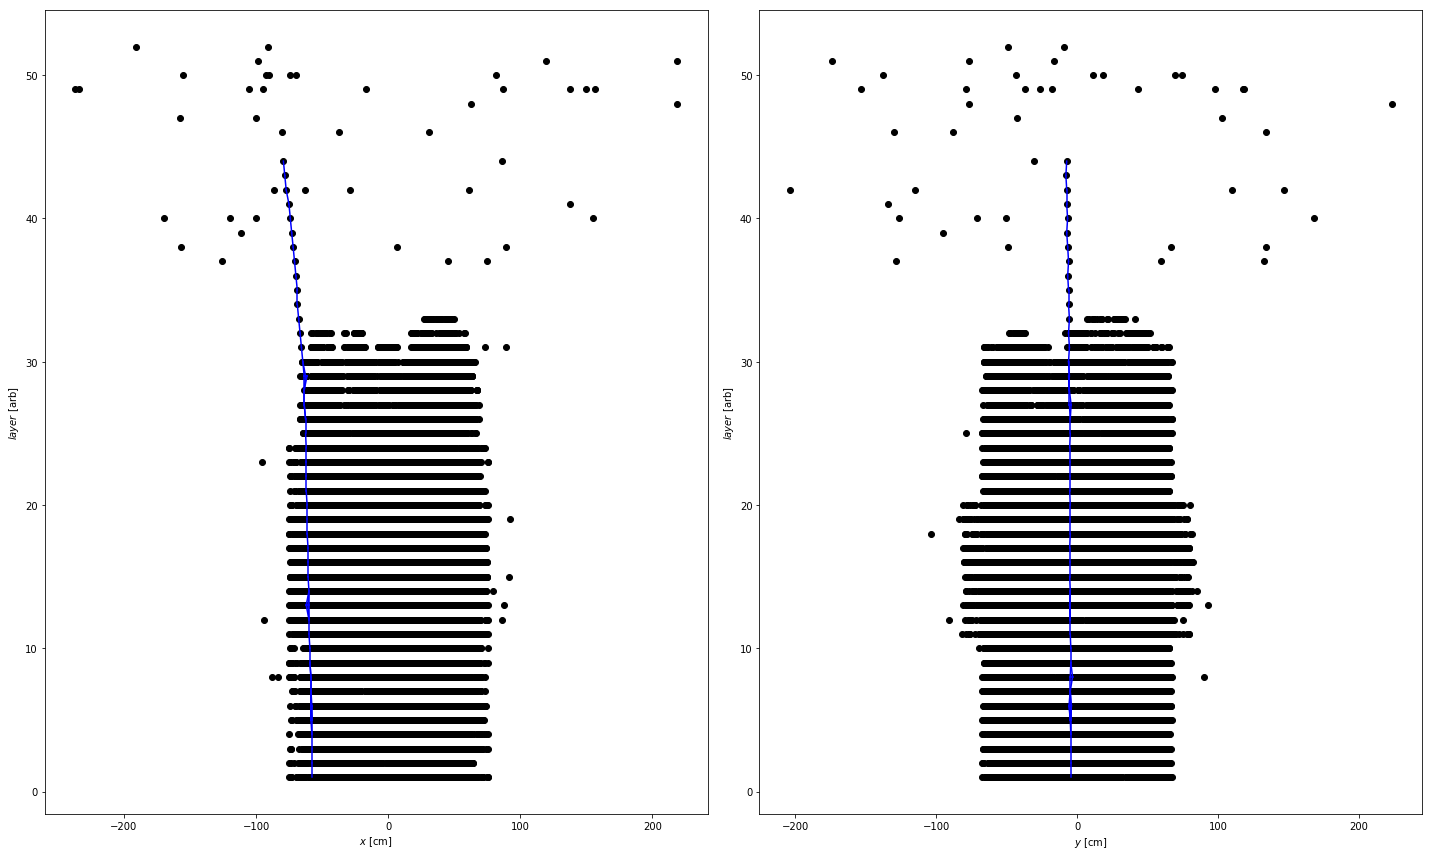

In [8]:
# Pull the inputs from the batcher
g = graph_from_sparse(graphs[0])
draw_sample(g.X, g.Ri, g.Ro, g.y)

## Train the model

In [9]:
# Model config
hidden_dim = 8
n_iters = 4
n_features = g.X.shape[1]

# Training config
batch_size = 1

n_epochs = 100
valid_frac = 0.5
test_frac = 0

In [10]:
# We round by batch_size to avoid partial batches
n_test = int(n_samples * test_frac) // batch_size * batch_size
n_valid = int(n_samples * valid_frac) // batch_size * batch_size
n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
n_train_batches = n_train // batch_size
n_valid_batches = n_valid // batch_size
n_test_batches = n_test #// batch_size

n_train, n_valid, n_test, n_train + n_valid + n_test

(1, 1, 0, 2)

In [11]:
# Partition the dataset
train_graphs, test_graphs = train_test_split(graphs, test_size=n_test)
train_graphs, valid_graphs = train_test_split(train_graphs, test_size=n_valid)

print('Train set size:', len(train_graphs))
print('Valid set size:', len(valid_graphs))
print('Test set size: ', len(test_graphs))

Train set size: 1
Valid set size: 1
Test set size:  0


In [12]:
# Prepare the batch generators
train_batcher = batch_generator(train_graphs, n_samples=n_train, batch_size=batch_size)
valid_batcher = batch_generator(valid_graphs, n_samples=n_valid, batch_size=batch_size, train=False)

In [13]:
model = SegmentClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters, masks_e=None, masks_n=None)
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda, l1 = 0)

2019-03-19 02:16:05.094183 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=5, out_features=8, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): MaskedLinear(in_features=26, out_features=8, bias=True)
      (1): Tanh()
      (2): MaskedLinear(in_features=8, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): MaskedLinear(in_features=39, out_features=8, bias=True)
      (1): Tanh()
      (2): MaskedLinear(in_features=8, out_features=8, bias=True)
      (3): Tanh()
    )
  )
)
2019-03-19 02:16:05.094385 Parameters: 665


In [14]:
estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=n_epochs,
              valid_generator=valid_batcher, n_valid_batches=n_valid_batches, 
              filename='test.pt')

2019-03-19 02:16:05.111619 Epoch 0


RuntimeError: CUDA out of memory. Tried to allocate 14.12 GiB (GPU 0; 11.17 GiB total capacity; 2.17 GiB already allocated; 8.71 GiB free; 1.35 MiB cached)

### Loss curves

In [ ]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.xlim(195,300)
#plt.ylim(.06,.08)
plt.legend(loc=0);

In [ ]:
# prepare test generator
with torch.no_grad():
    test_batcher = batch_generator(test_graphs, n_samples=n_test, batch_size=1, train=False)
    test_outputs = estim.predict(test_batcher, n_test_batches, concat=False)
    test_preds = [torch_to_np(o) for o in test_outputs]

    # Flatten the predictions and labels
    flat_y = np.concatenate([g.y.flatten() for g in test_graphs])
    flat_pred = np.concatenate([p.flatten() for p in test_preds])
    print(flat_y.shape)
    print(flat_pred.shape)

In [ ]:
def makeROC(flat_y, flat_pred, thresh=0.5):
    
    print('Test set results with threshold of', thresh)
    print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(flat_y, flat_pred>thresh))
    print('Precision: %.4f' % sklearn.metrics.precision_score(flat_y, flat_pred>thresh))
    print('Recall:    %.4f' % sklearn.metrics.recall_score(flat_y, flat_pred>thresh))
    
    # Compute the ROC curve
    fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)
    
    plt.figure(figsize=(9,2))

    # Plot the model outputs
    plt.subplot(131)
    binning=dict(bins=50, range=(0,1), histtype='bar')
    plt.hist(flat_pred[flat_y<thresh], label='fake', **binning)
    plt.hist(flat_pred[flat_y>thresh], label='true', **binning)
    #plt.xlim(.1,.125)
    plt.xlabel('Model output')
    plt.legend(loc=0)

    # Plot the ROC curve
    plt.subplot(132)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')

    # Plot the ROC curve
    plt.subplot(133)
    plt.semilogx(fpr, tpr)
    #plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.xlim(0, 1)
    plt.title('ROC curve')

    plt.tight_layout()

In [ ]:
#after training
makeROC(flat_y, flat_pred)